In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

# Chapter 2: Preprocessing Recording

In [2]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import imp

/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  


In [3]:
from collections import defaultdict
import time
import json

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal

In [5]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [6]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [8]:
import spikeinterface.core

In [23]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [9]:
import spikeinterface.full as si

In [10]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Electrophysiology Recording

- We are inputting the electrophsiology recording data with probe information. This should have been created in the prevous notebook in a directory created by Spike Interface. If you had already read in your own electrophsiology recording data with probe information with a different way, then follow these instructions.
    - If you want to use a different directory, then you must either:
        - Change `glob.glob({./path/to/with/*/raw_recording})` to the directory that you have the directories created from Spikeinterface. You can use a wildcard if you have multiple folders. You would replace `{./path/to/with/*/raw_recording}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.
        - Or change `(file_or_folder_or_dict={./path/to/raw_recording})`. You would replace `{./path/to/raw_recording}` with the path to either the parent directory or the actual directory containing the electrophsiology recording data read into Spikeinterface.

In [38]:
all_raw_recording_directories = glob.glob("./proc/**/raw_recording", recursive=True)

In [39]:
all_raw_recording_directories

['./proc/02172021_BLA4-1_3_Competition_Rec/raw_recording']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [40]:
raw_recording = spikeinterface.core.load_extractor(file_or_folder_or_dict=all_raw_recording_directories[0])

## Metadata from the recording file

- This is how you retrieve info from a :code:`RecordingExtractor`...



In [41]:
channel_ids = raw_recording.get_channel_ids()
fs = raw_recording.get_sampling_frequency()
num_chan = raw_recording.get_num_channels()
num_seg = raw_recording.get_num_segments()
duration = raw_recording.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 60771475
Number of hours: 0.8440482638888889


- Looking over the probe

In [42]:
probe_object = raw_recording.get_probegroup()

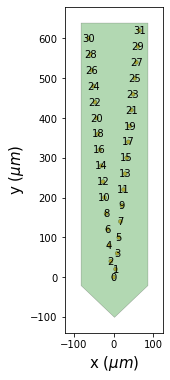

In [43]:
plot_probe_group(probe_object, same_axes=False, with_channel_index=True)
plt.show()

# Part 2: Preprocessing

- Preproccessing the signal to improve the spike sorting performance
- For more information and possible options, go to:
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_1_preprocessing.html

In [44]:
print("Properties before loading the probe:", list(raw_recording.get_property_keys()))

Properties before loading the probe: ['gain_to_uV', 'offset_to_uV', 'group', 'location', 'contact_vector']


In [45]:
# Bandpass Filtering, keeping all the points that are within a certain frequency range
recording_bandpass = st.bandpass_filter(raw_recording, freq_min=300, freq_max=6000)
print(recording_bandpass)

BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3038.574s


In [46]:
# Removing Bad Channels
recording_remove_bad_channels = st.preprocessing.remove_bad_channels(recording_bandpass)
print(recording_remove_bad_channels)

RemoveBadChannelsRecording: 32 channels - 1 segments - 20.0kHz - 3038.574s


In [47]:
# Re-referencing
recording_common_reference = st.common_reference(recording_remove_bad_channels, reference='global', operator='median')
print(recording_common_reference)


CommonReferenceRecording: 32 channels - 1 segments - 20.0kHz - 3038.574s


## Saving the Preprocessed files to folder

# TODO: See which preprocessing Maya does and remove all the unnecessry ones

In [48]:
all_parent_recording_directories = glob.glob("./proc/*")

In [49]:
all_parent_recording_directories

['./proc/02172021_BLA4-1_3_Competition_Rec']

- If you have more than one recording directory, then you must either:
    - A. Put the index of the file in `all_recording_directories[0]` below. You would replace the `0` with the correct index. (Remember, Python is zero indexed so the first file in the list is 0. Second is 1, and so forth.
    - B. Add a absolute or relative path to `(file_or_folder_or_dict={./path/to/recording_file.rec}`) below. You would replace `{./path/to/recording_file.rec}` with the path of the file for the metadata.

In [52]:
parent_output_directory = all_parent_recording_directories[0]

In [53]:
preprocessing_output_directory = os.path.join(parent_output_directory, "preprocessing")


In [55]:
recording_output_directory = os.path.join(parent_output_directory, "preprocessing")

In [57]:
if not os.path.exists(recording_output_directory):
    recording_common_reference.save_to_folder(name="common_reference_recording", folder=recording_output_directory)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(recording_output_directory))

write_binary_recording with n_jobs 1  chunk_size None


In [36]:
output_folder = "./proc/recording_extractor/common_reference_recording"
if not os.path.exists(os.path.join(output_folder, "cached.json")):
    recording_common_reference.save_to_folder(name="common_reference_recording", folder=output_folder)
else:
    print("Directory already exists for: {}".format(output_folder))


Directory already exists for: ./proc/recording_extractor/common_reference_recording


In [74]:
print("Properties after loading the probe:", list(recording_common_reference.get_property_keys()))

Properties after loading the probe: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group']


- Applying seperate preprocessing technique to see the difference

In [37]:
# Notch Filtering
recording_notch = st.preprocessing.notch_filter(recording_bandpass, freq=2000, q=30)
print(recording_notch)

NotchFilterRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s


### Plotting Power Spectrum

- Now let’s plot the power spectrum of non-filtered, bandpass filtered, and notch filtered recordings.

In [38]:
# The sampling frequency of the recording
fs = recording.get_sampling_frequency()
fs

20000.0

- Getting the power spectral density using Welch’s method for 0th segment
    - To access a given channel, index it like this: `raw_recording_traces[:, 0]` (0 is the number of the channel)
    - Commented out code is already ran, and the output is saved to a file to save time. Ur having issues with Jupyter Notebook not dying while running

In [39]:
with open('./proc/trace_arrays/raw_recording_traces.npy', 'rb') as input_file:
    raw_recording_traces = np.load(input_file)

In [40]:
f_raw, p_raw = scipy.signal.welch(raw_recording_traces[:, 0], fs=fs)

In [41]:
with open('./proc/trace_arrays/bandpass_recording_traces.npy', 'rb') as input_file:
    bandpass_recording_traces = np.load(input_file)

In [42]:
f_bandpass, p_bandpass = scipy.signal.welch(bandpass_recording_traces[:, 0], fs=fs)

In [43]:
with open('./proc/trace_arrays/remove_bad_channels_recording_traces.npy', 'rb') as input_file:
    remove_bad_channels_recording_traces = np.load(input_file)

In [44]:
f_remove_bad_channels, p_remove_bad_channels = scipy.signal.welch(remove_bad_channels_recording_traces[:, 0], fs=fs)

- Plotting the power spectral density(https://en.wikipedia.org/wiki/Spectral_density)
    - Plotting the Semilog (https://www.mathworks.com/help/matlab/ref/semilogy.html) which plots the y-axis as powers of 10's
    - The X axis is the "Array of sample frequencies."
    - The Y axis is the "Power spectral density or power spectrum of X"
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html


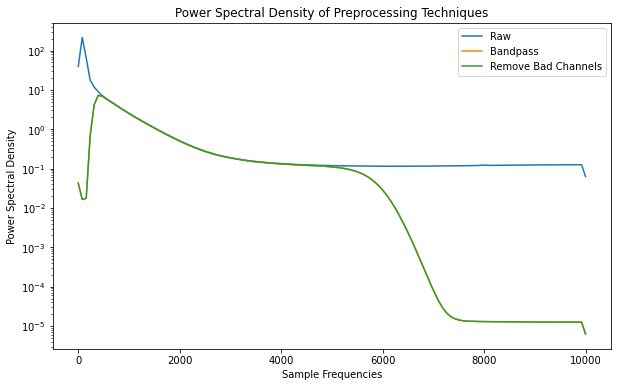

In [46]:
fig, ax = plt.subplots()
ax.semilogy(f_raw, p_raw, label="Raw")
ax.semilogy(f_bandpass, p_bandpass, label="Bandpass")
# ax.semilogy(f_notch, p_notch, label="Notch")
ax.semilogy(f_remove_bad_channels, p_remove_bad_channels, label="Remove Bad Channels")
# ax.semilogy(f_common_reference, p_common_reference, label="Common Reference")

plt.xlabel("Sample Frequencies")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density of Preprocessing Techniques")
plt.legend()
plt.show()

## Computing Local Field Potential and Multi-Unit Activity

- "Local field potentials (LFP) are low frequency components of the extracellular recordings." 
- "Multi-unit activity (MUA) are rectified and low-pass filtered recordings showing the diffuse spiking activity."
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_1_preprocessing.html

- Code Commented out because memory in Jupyter Notebook keeps running out of memory

In [47]:
recording_lfp = st.preprocessing.bandpass_filter(recording, freq_min=1, freq_max=300)
recording_mua = st.preprocessing.rectify(recording)

In [48]:
recording_lfp

BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s

In [49]:
recording_mua

RectifyRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s

## Changing the Reference

- Rereferencing the signal to reduce the common mode noise from the recording
    - https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_1_preprocessing.html
- Average/median can be computed on different groups. 
- Single channels can also be used as reference.

In [50]:
recording_car = st.common_reference(recording, reference='global', operator='average')
recording_cmr = st.common_reference(recording, reference='global', operator='median')
recording_single = st.common_reference(recording, reference='single', ref_channels=[1])
# recording_single_groups = st.common_reference(recording, reference='single',
#                                               groups=[["0", "1"], ["2", "3"]],
#                                               ref_channels=["1", "2"])

- Changing the reference and getting the reference causes the memory to run out of the computer so, commented out

- We will create a folder using a function that save the extractor to folder.
    - You will import extractor with the `spikeinterface.core.load_extractor` function. Reference the folder that you created
        - For example: `recording = spikeinterface.core.load_extractor(file_or_folder_or_dict="./pickles/recording_extractor/raw_recording")`
    - https://spikeinterface.readthedocs.io/en/latest/api.html

# Visualization and EDA

## Plotting the Time Series

- Plotting with lines are better for recordings with smaller channel numbers

In [59]:
time_range = [11, 16]

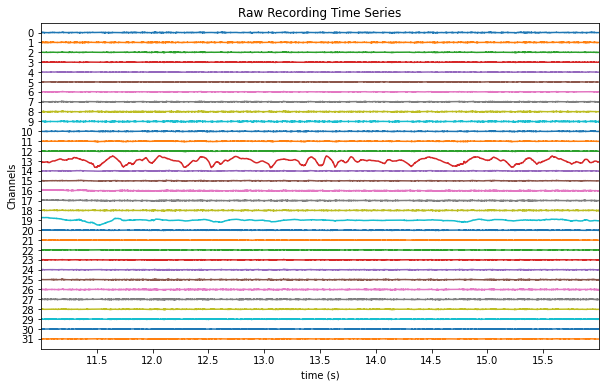

In [60]:
sw.plot_timeseries(recording, time_range=time_range, show_channel_ids=True)
plt.title("Raw Recording Time Series")
plt.ylabel("Channels")
plt.show()

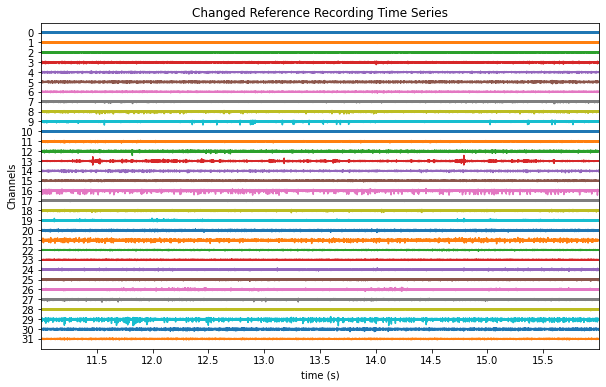

In [61]:
sw.plot_timeseries(recording_common_reference, time_range=time_range, show_channel_ids=True)
plt.title("Changed Reference Recording Time Series")
plt.ylabel("Channels")
plt.show()

- Heat map is better for high channel counts

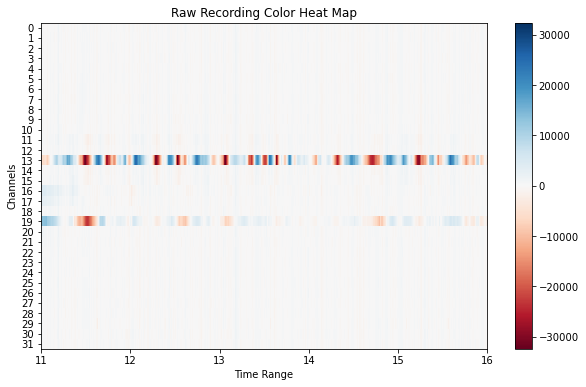

In [62]:
w_ts = sw.plot_timeseries(recording, time_range=time_range, mode="map", show_channel_ids=True,)
plt.title("Raw Recording Color Heat Map")
plt.xlabel("Time Range")
plt.ylabel("Channels")
plt.show()

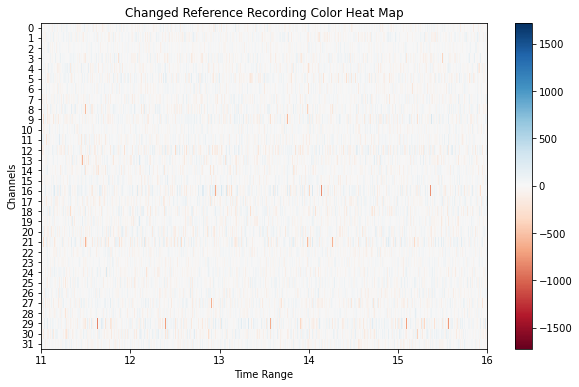

In [63]:
w_ts = sw.plot_timeseries(recording_common_reference, time_range=time_range, mode="map", show_channel_ids=True,)
plt.title("Changed Reference Recording Color Heat Map")
plt.xlabel("Time Range")
plt.ylabel("Channels")
plt.show()

- Looking more closely at a few of the channels
    - The Channel IDs:

In [65]:
recording_common_reference.channel_ids

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U2')

In [66]:
channel_ids=['0', '6', '13', '19', '30']

- With Raw Recording

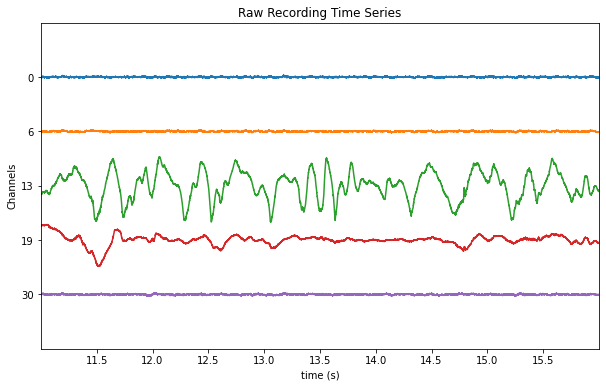

In [67]:
# plt_kwargs = {'linewidth': 0.05}
# fig, ax = plt.subplots(1,1, figsize=(10,10), **plt_kwargs)
sw.plot_timeseries(recording, time_range=time_range,
                  channel_ids=channel_ids, show_channel_ids=True)
plt.title("Raw Recording Time Series")
plt.ylabel("Channels")
plt.show()

- With Bandpass Filtering

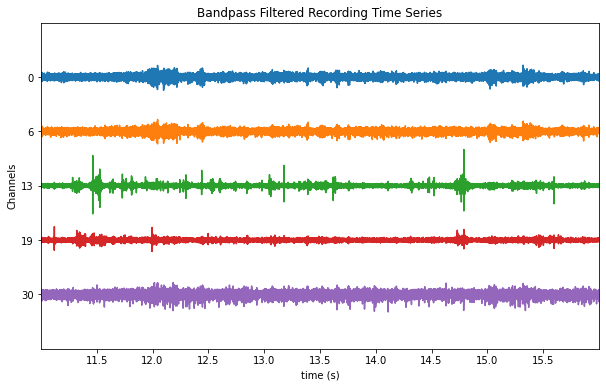

In [68]:
sw.plot_timeseries(recording_bandpass, time_range=time_range,
                  channel_ids=channel_ids, show_channel_ids=True)
plt.title("Bandpass Filtered Recording Time Series")
plt.ylabel("Channels")
plt.show()

- With bad channels removes

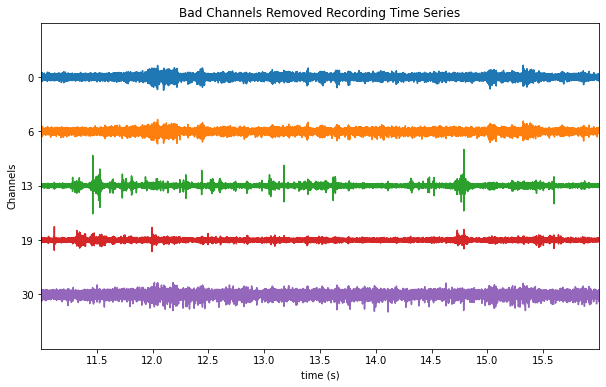

In [69]:
sw.plot_timeseries(recording_remove_bad_channels, time_range=time_range,
                  channel_ids=channel_ids, show_channel_ids=True)
plt.title("Bad Channels Removed Recording Time Series")
plt.ylabel("Channels")
plt.show()

- With Reference changed

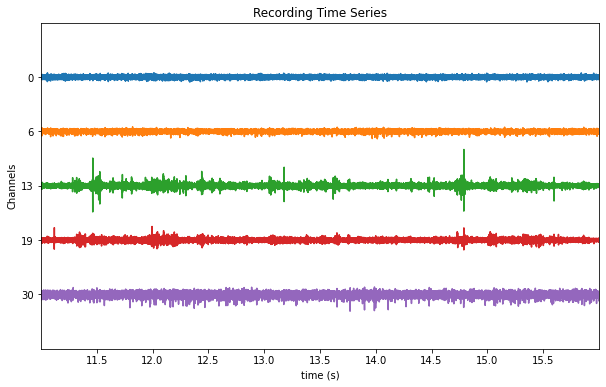

In [70]:
sw.plot_timeseries(recording_common_reference, time_range=time_range,
                  channel_ids=channel_ids, show_channel_ids=True)
plt.title("Recording Time Series")
plt.ylabel("Channels")
plt.show()

- With Notch Filtering

In [71]:
sw.plot_timeseries(recording_notch, time_range=time_range,
                  channel_ids=channel_ids, show_channel_ids=True)
plt.title("Notch Filtered Recording Time Series")
plt.ylabel("Channels")
plt.show()

NameError: name 'recording_notch' is not defined

- Local field potentials (LFP) 

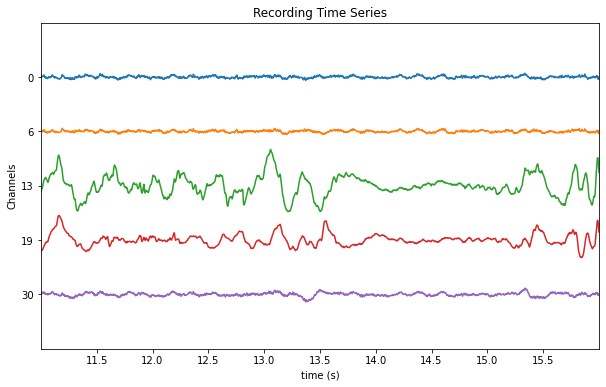

In [63]:
sw.plot_timeseries(recording_lfp, time_range=time_range,
                  channel_ids=channel_ids, show_channel_ids=True)
plt.title("Recording Time Series")
plt.ylabel("Channels")
plt.show()

- Multi Unit Activity

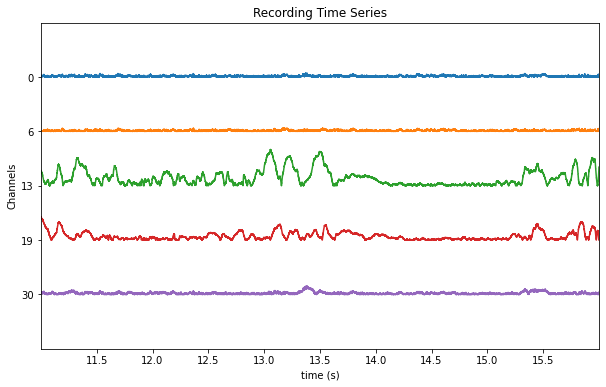

In [64]:
sw.plot_timeseries(recording_mua, time_range=time_range,
                  channel_ids=channel_ids, show_channel_ids=True)
plt.title("Recording Time Series")
plt.ylabel("Channels")
plt.show()

# Part 4: Sorting

Now you are ready to spike sort using the :code:`sorters` module!
Let's first check which sorters are implemented and which are installed



In [65]:
print('Available sorters', ss.available_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'pykilosort', 'spykingcircus', 'tridesclous', 'waveclus', 'yass']


The :code:`ss.installed_sorters()` will list the sorters installed in the machine.
We can see we have mountainsort4 and Tridesclous installed.
Spike sorters come with a set of parameters that users can change.
The available parameters are dictionaries and can be accessed with:



In [66]:
print(ss.get_default_params('mountainsort4'))

{'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'num_workers': 1, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10}


Let's run mountainsort4 and change one of the parameter, say, the detect_threshold:



In [67]:
ms4_params = ss.get_default_params('mountainsort4').copy()

- Changing the default parameters for these parameters
    - These are the parameters changed in Maya's video

In [68]:
ms4_params['adjacency_radius'] = 100
ms4_params['detect_sign'] = 0
ms4_params['filter'] = False
ms4_params['num_workers'] = 8
ms4_params['detect_interval'] = 30

- Sorting usually takes at least a hour. Uncomment the code block below to run it. 

In [69]:
sorting_ms4 = ss.read_sorter_folder("./proc/mountainsort4_output")

- Plotting the Rasters

Text(0, 0.5, 'Unit IDs')

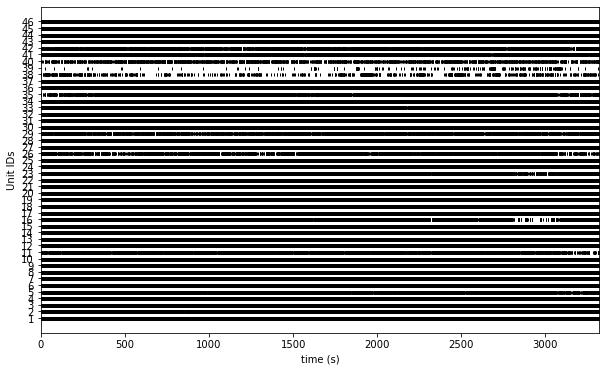

In [72]:
sw.plot_rasters(sorting_ms4)
plt.ylabel("Unit IDs")

# TODO:

- Add preprocessing cells from https://github.com/SpikeInterface/spiketutorials/blob/master/Official_Tutorial_SI_0.94_May2022/SpikeInterface_Tutorial.ipynb
    - https://anaconda.org/conda-forge/ephyviewer